In [50]:
import numpy as np
import pandas as pd


def generate_data(num_tags=20, num_reads=100, noise_std=0):

    item_idx = np.arange(num_tags)
    x = np.random.uniform(0, 50, num_tags)
    y = np.random.uniform(0, 70, num_tags)

    log_freq = np.log10(np.random.choice([780, 820, 860], (num_tags, num_reads), replace=True))

    # Uniform grid of antenna to choose from
    tx_x = np.random.choice(np.linspace(0, 50, 10), (num_tags, num_reads))
    tx_y = np.random.choice(np.linspace(0, 70, 10), (num_tags, num_reads))

    rx_x = np.random.choice(np.linspace(0, 50, 10), (num_tags, num_reads))
    rx_y = np.random.choice(np.linspace(0, 70, 10), (num_tags, num_reads))

    log_distance = (
        np.log10(np.linalg.norm(np.stack([tx_x, tx_y], axis=-1) - np.stack([x[:, None], y[:, None]], axis=-1), axis=-1))
        + np.log10(np.linalg.norm(np.stack([rx_x, rx_y], axis=-1) - np.stack([x[:, None], y[:, None]], axis=-1), axis=-1))
    )

    distance_coef, freq_coef, const = 100, 50, 520
    obs_signal_loss = log_distance * distance_coef  + log_freq * freq_coef + const # + np.random.normal(0, noise_std, (num_tags, num_reads))
    if noise_std > 0:
        obs_signal_loss += np.random.normal(0, noise_std, (num_tags, num_reads))

    return pd.DataFrame(
        {
            "obs_signal_loss": obs_signal_loss.flatten(),
            "log_freq": log_freq.flatten(),
            "log_distance": log_distance.flatten(),
            "item_idx": np.repeat(item_idx, num_reads),
            "x": np.repeat(x, num_reads),
            "y": np.repeat(y, num_reads),
            "tx_x": tx_x.flatten(),
            "tx_y": tx_y.flatten(),
            "rx_x": rx_x.flatten(),
            "rx_y": rx_y.flatten(),
        }
    )

In [51]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
train = generate_data(num_tags=200, num_reads=10, noise_std=10)
test = generate_data(num_tags=3, num_reads=100, noise_std=10)

distance_scalar, freq_scalar = StandardScaler(), StandardScaler()
distance_scalar.fit(train.log_distance.values.reshape(-1, 1))
freq_scalar.fit(train.log_freq.values.reshape(-1, 1))

StandardScaler()

In [52]:
import numpy as np
import numpyro
import numpyro.distributions as dist


def model(
    log_distance,
    log_freq,
    obs_signal_loss=None,
):
    log_distance_coef = numpyro.sample("distance_coef", dist.Normal(0, 200))
    log_freq_coef = numpyro.sample("freq_coef", dist.Normal(0, 100))
    const = numpyro.sample("const", dist.Normal(800, 1000))
    noise = numpyro.sample("noise", dist.HalfNormal(scale=20))

    log_distance = distance_scalar.transform(np.array(log_distance).reshape(-1, 1)).flatten()
    log_freq = freq_scalar.transform(np.array(log_freq).reshape(-1, 1)).flatten()

    numpyro.sample(
        "signal_loss", dist.Normal(log_distance * log_distance_coef + log_freq * log_freq_coef + const, noise), obs=obs_signal_loss
    )

In [53]:
from numpyro.infer import NUTS, MCMC
from jax import random

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_tags = 10000
mcmc = MCMC(kernel, 
            num_warmup=1000, 
            num_samples=num_tags,
            num_chains=2,
            thinning = 1)
mcmc.run(
    rng_key_, 
    log_freq=train.log_freq.values, 
    obs_signal_loss=train.obs_signal_loss.values, 
    log_distance=train.log_distance.values
)
mcmc.print_summary()
posterior = mcmc.get_samples()

/tmp/ipykernel_641/1354448343.py:11: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel,
sample: 100%|██████████| 11000/11000 [00:04<00:00, 2623.91it/s, 3 steps of size 7.80e-01. acc. prob=0.90]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          const    958.67      0.23    958.67    958.29    959.03  19814.09      1.00
  distance_coef     39.46      0.23     39.46     39.09     39.83  24521.24      1.00
      freq_coef      1.32      0.23      1.32      0.94      1.68  20357.14      1.00
          noise     10.03      0.16     10.03      9.77     10.30  23075.75      1.00

Number of divergences: 0


# Trace plot

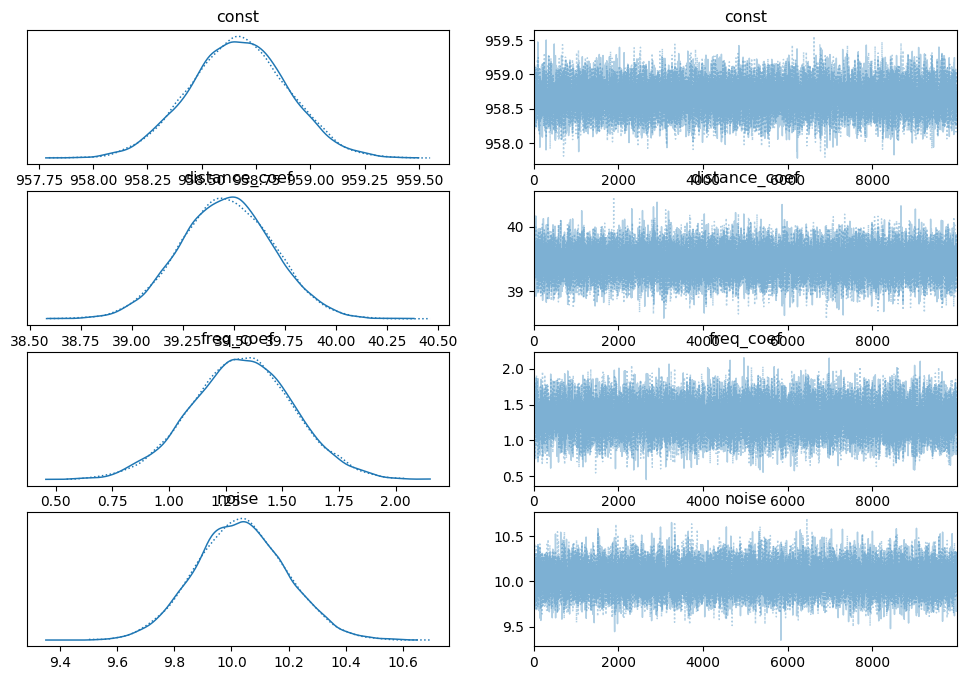

In [54]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);


# Pairs plot

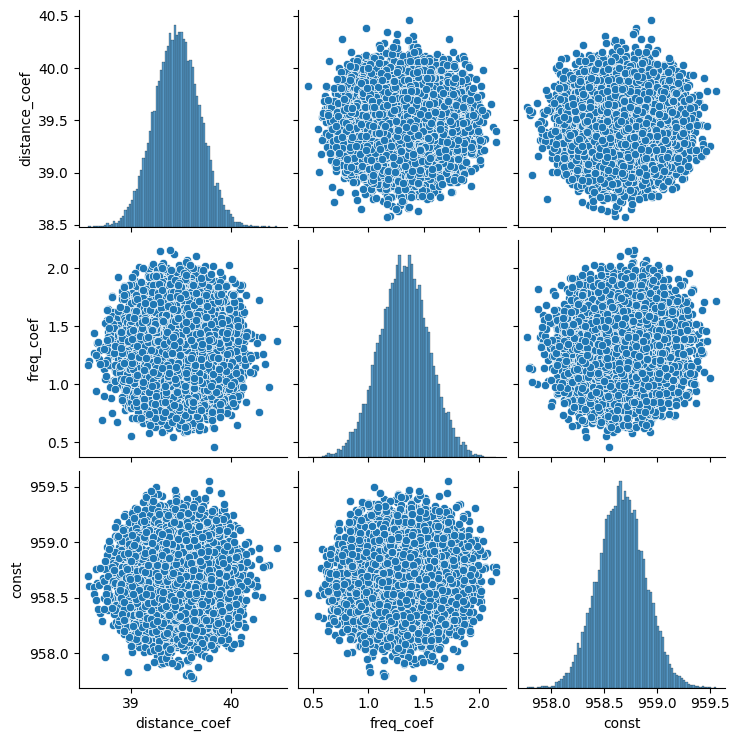

In [55]:
# Pairs plot
import seaborn as sns

vars = ["distance_coef", "freq_coef", "const"]#, "noise"]
sns.pairplot(pd.DataFrame(posterior), x_vars=vars, y_vars=vars);


In [56]:
import altair as alt

def plot_regression(x, y, y_mean, y_hpdi):
    results = pd.DataFrame(
        {
            "Covariate": x,
            "Response": y,
            "Response (predicted)": y_mean,
            r"Response (5% confidence)": y_hpdi[0, :],
            r"Response (95% confidence)": y_hpdi[1, :],
        }
    )
    base = alt.Chart(results)

    return alt.layer(
        base.mark_circle().encode(
            alt.X("Covariate", scale=alt.Scale(zero=False)),
            alt.Y("Response", scale=alt.Scale(zero=False), title="Response"),
        ),
        base.mark_line().encode(
            x="Covariate",
            y=alt.Y("Response (predicted)", title="Response"),
        ),
        alt.Chart(results)
        .mark_area(opacity=0.3)
        .encode(
            x="Covariate",
            y=alt.Y(r"Response (5% confidence)", title="Response"),
            y2=alt.Y2(r"Response (95% confidence)", title="Response"),
        ),
    )

# Prior predictive checks

In [57]:
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(
    rng_key_,
    log_distance=train.log_distance.values,
    log_freq=train.log_freq.values,
)["signal_loss"]

mean_prior_pred = np.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

plot_regression(
    train.log_distance.values, train.obs_signal_loss.values, mean_prior_pred, hpdi_prior_pred
) | plot_regression(
    train.log_freq.values, train.obs_signal_loss.values, mean_prior_pred, hpdi_prior_pred
)

alt.HConcatChart(...)

# Posterior predictive checks

In [58]:
rng_key, rng_key_ = random.split(rng_key)
posterior_predictive = Predictive(model, posterior)
plots = []
for log_freq, subset in train.groupby("log_freq"):
    posterior_predictions = posterior_predictive(
        rng_key_,
        log_distance=subset.log_distance.values,
        log_freq=log_freq,
    )["signal_loss"]

    mean_posterior_pred = np.mean(posterior_predictions, axis=0)
    hpdi_posterior_pred = hpdi(posterior_predictions, 0.95)
    

    plots.append(plot_regression(
        subset.log_distance.values, subset.obs_signal_loss.values, mean_posterior_pred, hpdi_posterior_pred
    ).properties(title=f"log_freq = {log_freq}"))

alt.hconcat(*plots)

alt.HConcatChart(...)

# Posterior distributions

In [59]:
import altair as alt

base = alt.Chart(pd.DataFrame(posterior).head(5000)).mark_bar().encode(y="count()")
base.encode(
    x=alt.X("distance_coef:O").bin(maxbins=20),
) | base.encode(
    x=alt.X("freq_coef:O").bin(maxbins=20),
) | base.encode(
    x=alt.X("const:O").bin(maxbins=20),
) | base.encode(
    x=alt.X("noise:O").bin(maxbins=20),
)

alt.HConcatChart(...)

# Using coefficients as priors

In [60]:
from scipy.stats import norm, truncnorm

mu_distance_coef, sigma_distance_coef = norm.fit(posterior["distance_coef"])
mu_freq_coef, sigma_freq_coef = norm.fit(posterior["freq_coef"])
mu_const, sigma_const = norm.fit(posterior["const"])
# mu_noise, sigma_noise, _, _ = truncnorm.fit(posterior["noise"])

In [105]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def item_model(log_freq, obs_signal_loss, tx_x, tx_y, rx_x, rx_y, mu_distance_coef, sigma_distance_coef, mu_freq_coef, sigma_freq_coef, mu_const, sigma_const):
    distance_coef = mu_distance_coef #numpyro.sample("distance_coef", dist.Normal(mu_distance_coef, sigma_distance_coef))
    freq_coef = mu_freq_coef # numpyro.sample("freq_coef", dist.Normal(mu_freq_coef, sigma_freq_coef))
    const = mu_const # numpyro.sample("const", dist.Normal(mu_const, sigma_const))
    noise = 10 # numpyro.sample("noise", dist.TruncatedNormal(mu_noise, scale=sigma_noise))

    # x = numpyro.sample("x", dist.Normal(25, 50))
    # y = numpyro.sample("y", dist.Normal(35, 70))
    x = numpyro.sample("x", dist.Uniform(0, 50))
    y = numpyro.sample("y", dist.Uniform(0, 70))

    log_distance = (
        jnp.log10(jnp.linalg.norm(jnp.stack([tx_x, tx_y], axis=-1) - jnp.stack([x, y], axis=-1), axis=-1))
        + jnp.log10(jnp.linalg.norm(jnp.stack([rx_x, rx_y], axis=-1) - jnp.stack([x, y], axis=-1), axis=-1))
    )

    log_distance = (log_distance  - distance_scalar.mean_) / distance_scalar.scale_
    log_freq = freq_scalar.transform(log_freq.reshape(-1, 1)).flatten()

    numpyro.sample("signal_loss", dist.Normal(log_distance * distance_coef + log_freq * freq_coef + const, noise), obs=obs_signal_loss)


In [108]:

from numpyro.infer import NUTS, MCMC
from jax import random

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(item_model)
mcmc = MCMC(kernel, 
            num_warmup=1000, 
            num_samples=8000,
            num_chains = 2)
for item_idx, test_item in test.groupby("item_idx"):
    print(f"{item_idx}: ({test_item.x.unique()}, {test_item.y.unique()}")
    mcmc.run(
        rng_key_,
        log_freq=test_item.log_freq.values,
        obs_signal_loss=test_item.obs_signal_loss.values,
        tx_x=test_item.tx_x.values,
        tx_y=test_item.tx_y.values,
        rx_x=test_item.rx_x.values,
        rx_y=test_item.rx_y.values,
        mu_distance_coef=mu_distance_coef,
        sigma_distance_coef=sigma_distance_coef,
        mu_freq_coef=mu_freq_coef,
        sigma_freq_coef=sigma_freq_coef,
        mu_const=mu_const,
        sigma_const=sigma_const,
        #  init_params={"x": np.tile(test_item.x.unique(), 2), "y": np.tile(test_item.y.unique(), 2)}
    )
    mcmc.print_summary()
    break

/tmp/ipykernel_641/2098473057.py:10: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel,


0: ([20.44864517], [64.05889294]


sample: 100%|██████████| 9000/9000 [00:01<00:00, 4824.27it/s, 7 steps of size 7.28e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x     20.48      0.29     20.47     20.01     20.94   8107.82      1.00
         y     63.63      0.34     63.64     63.09     64.21   8223.46      1.00

Number of divergences: 0


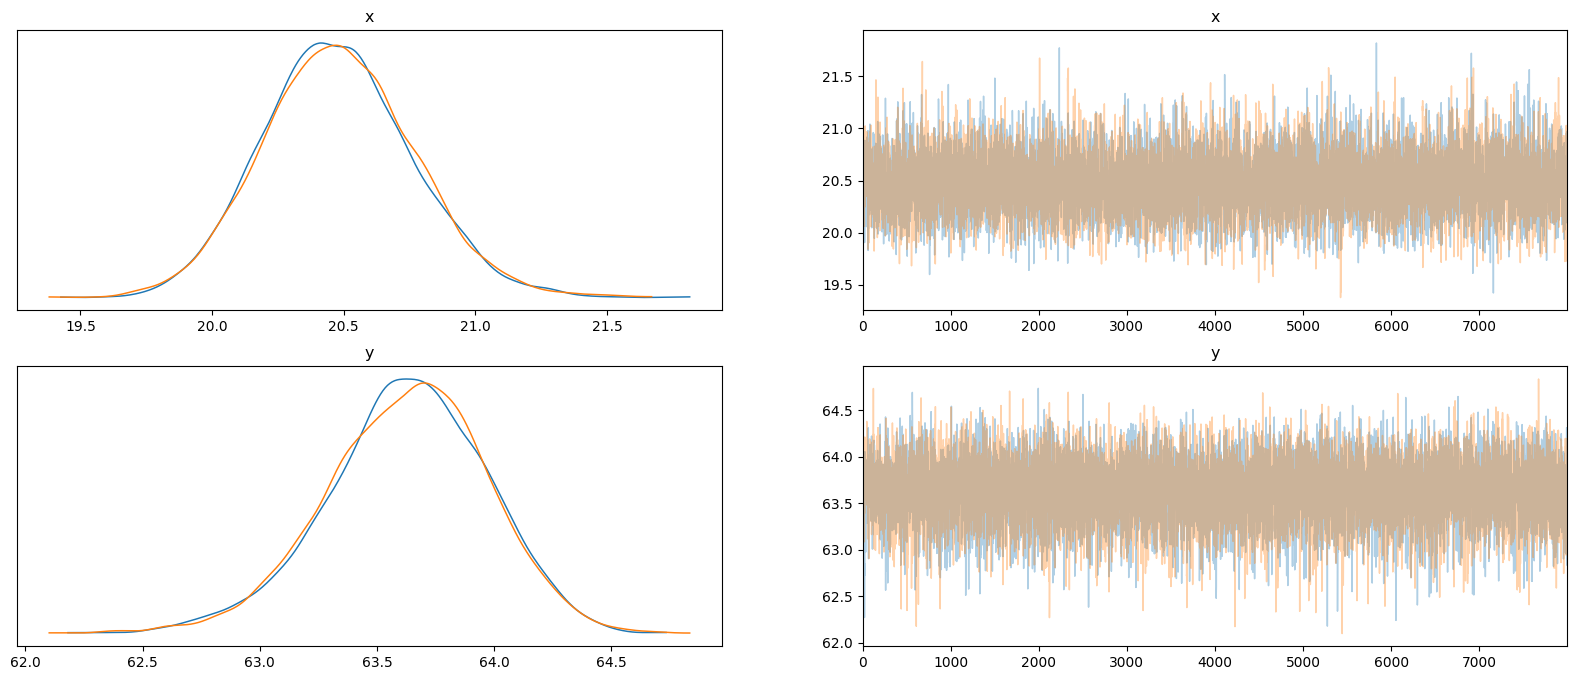

In [109]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=False, figsize=(20, 8));


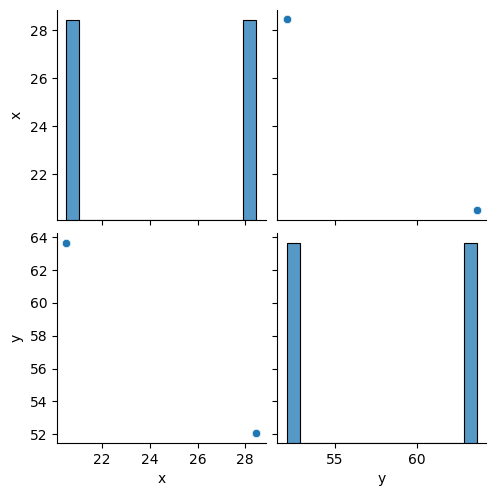

In [104]:
# Pairs plot
import seaborn as sns

posterior = mcmc.get_samples()
vars = ["x", "y"]
sns.pairplot(pd.DataFrame(posterior), x_vars=vars, y_vars=vars);